<a href="https://colab.research.google.com/github/SoniaPMi/AI-3-PyTorch/blob/main/Text_generation_jokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text generation in PyTorch using LSTMs

This example tries to use LSTMs in seq2seq scheme to predict next words in a joke, given a seed string.

## Main imports

In [8]:
import torch
from torch import nn, optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import pandas as pd

## Device selection

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data

In [4]:
#get item: 

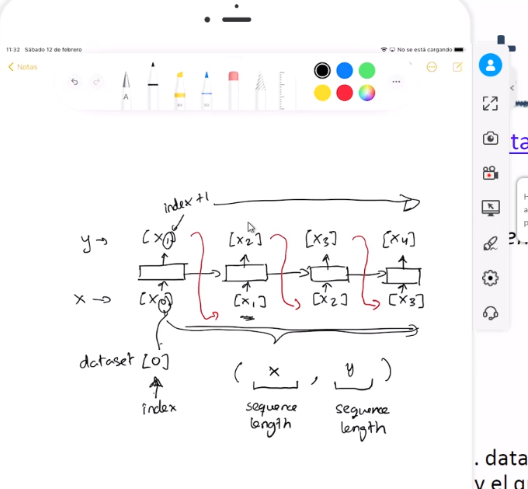

We will use Reddit clean jokes dataset to train the network. Let us create a function to create a Dataset (for help on custom PyTorch Datasets check [this link](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class))

In [14]:
#, dataloader
import pandas as pd
from collections import Counter
import re

class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        sequence_length
    ):
        self.sequence_length = sequence_length # completar
        self.words = self.load_words() # completar
        self.uniq_words = self.get_uniq_words() # completar

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        train_df = pd.read_csv('/content/reddit-cleanjokes.csv')
        text = train_df['Joke'].str.cat(sep=' ')
        #text = re.sub(r'[^\W\S', '', text).lower() 
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]),
        )
#

Test the Dataset class

In [15]:
sequence_length=4
dataset=Dataset(sequence_length=sequence_length)
print(len(dataset))
print(dataset[0])
print(dataset[1])
print(len(dataset.get_uniq_words()))

23910
(tensor([  2,   8,   0, 248]), tensor([  8,   0, 248,  20]))
(tensor([  8,   0, 248,  20]), tensor([  0, 248,  20,   4]))
6925


# Model

Define a model based on LSTM with default input_size=128, hidden_size=128, num_layers=1

In [19]:
class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 1

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            #dropout = 0.2, # esto para cuando uso más de una capa
            bidirectional=False
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)                           


    def forward(self, x, prev_state):
        embed = self.embbeding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

model=Model(dataset).to(device)
print(model)        


Model(
  (embedding): Embedding(6925, 128)
  (lstm): LSTM(128, 128)
  (fc): Linear(in_features=128, out_features=6925, bias=True)
)


## Training

In [25]:
batch_size=256
max_epochs=20

model.train()

dataloader = DataLoader(dataset, batch_size=batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(max_epochs):
  state_h, state_c = model.init_state(sequence_length)

  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred, _ = model(x, (state_h.to(device), state_c.to(device))) #to devide llevarlos a la gpu 
    loss = criterion(y_pred.transpose(1, 2), y)
    loss.backward()
    optimizer.step()

    print({ 'epoch': epoch+1, 'batch': batch+1, 'loss': loss.item() })

AttributeError: ignored

## Predict

In [ ]:
next_words=100
model.eval()

text='Knock knock. Whos there?'
words = text.# completar
state_h, state_c = # completar

for i in range(0, next_words):
  x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
  y_pred, (state_h, state_c) = model(# completar)

  last_word_logits = # completar
  p = torch.nn.functional.softmax(# completar)
  word_index = np.random.choice(# completar)
  words.append(# completar)

print(words)